In [2]:
%pip install "transformers>=4.11.3" sentencepiece sentencepiece scikit-plot wordcloud openpyxl autopep8 nlpaug "torch==1.8" nltk seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix
from wordcloud import WordCloud
import nlpaug.augmenter.word as naw
import json

/root/miniconda3/envs/pydml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
initial_df = pd.read_excel("Dataset.xlsx", index_col=None, usecols="A:B")
initial_df

,Column1.data.text,Emotion
0,@RouleLaCookie @luXemusicBX @toda_pisteur Non ...,Dégoût
1,@YarrV @m_nguea Oui cest quand même un gros ra...,Dégoût
2,@salzermorrayOFF @OMjee972 @Diamarc10 @LordDos...,Colère
3,Booba il parle que du père de Vald mais on s'e...,Colère
4,@RGang972 Oui bon sachons raison garder quand ...,INCONNU
...,...,...
964,Finito booba c’est très grave https://t.co/APC...,Dégoût
965,@lilcamscar @nolabuche @vald_ld ça c’est vous ...,Joie
966,@RapAtlas_ Si Booba ne change pas de trottoir,INCONNU
967,Au moins il es premier lui… https://t.co/KZku8...,INCONNU


<AxesSubplot:xlabel='Emotion', ylabel='count'>

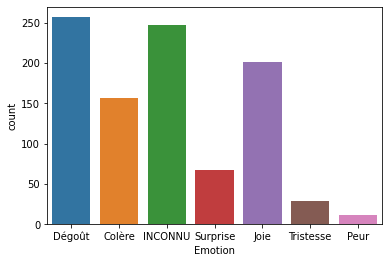

In [6]:
sns.countplot(x=initial_df.Emotion)

In [7]:
cleaned_df = initial_df.replace(to_replace="(@\w+)|(http[a-zA-Z\:\/\.]+)", value ="", regex=True)
def custom_encoder(df):
    df = df.replace(to_replace ="Surprise", value =6)
    df = df.replace(to_replace ="Joie", value =5)
    df = df.replace(to_replace ="Dégoût", value =4)
    df = df.replace(to_replace ="Peur", value =3)
    df = df.replace(to_replace ="Colère", value =2)
    df = df.replace(to_replace ="Tristesse", value =1)
    df = df.replace(to_replace ="INCONNU", value =0)
    return df
cleaned_df = custom_encoder(cleaned_df)
# Since we have our own way of tagging, we need to randomize the set
cleaned_df = cleaned_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [8]:
lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('french'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [20]:
cv = CountVectorizer(ngram_range=(1,2), strip_accents="ascii")
X_train, X_test, y_train, y_test = train_test_split(cleaned_df['Column1.data.text'], cleaned_df['Emotion'],  test_size=0.2, random_state=1)

In [14]:
# aug1 = naw.SynonymAug(aug_src='wordnet', lang="fra")

# Do not run pliz
# aug1 = naw.SynonymAug(aug_src='ppdb', lang="fra",
#                       model_path="ppdb-1.0-s-lexical")
# aug2 = naw.BackTranslationAug(
#     from_model_name='Helsinki-NLP/opus-mt-fr-en',
#     to_model_name='Helsinki-NLP/opus-mt-en-fr',
#     device="cpu"
# )


# def augment_text(array):
#     new_text = list()
#     for i, elm in enumerate(array):
#         print(f"Processing entry {i+1}/{len(array)} : {str(elm)}")
#         augmented_text1 = aug1.augment(elm, num_thread=16)
#         new_text.append(augmented_text1)
#         augmented_text2 = aug2.augment(augmented_text1, num_thread=16)
#         new_text.append(augmented_text2)
#         print("Found: " + augmented_text1 + " and " + augmented_text2)
#     return new_text


# augmented_text = augment_text(X_train)
# with open('augmented_text.json', 'w') as outfile:
#     json.dump(augmented_text, outfile)

Processing entry 1/775 :     Quand t'as vendu 50k de physique en 1iere semaine c'est logique de chuter comme ça néanmoins ça reste une très grosse 2ieme semaine (on rapelle que certains vendrait leur mère pour avoir ça en 1iere semaine)
Found: Quand t ' as vendu 50k de physique en 1iere semaine c. ' est logiques de chuter aimes ça néanmoins ça reste a três gros 2ieme semaine (on rapelle que certaines vendrait leur mère pour a que par 1iere semaine ) and Quand vous avez vendu 50k de physique dans la première semaine c. il est logique de tomber comme ça bien qu'il reste une très grande 2e semaine (rappelez-vous que certains vendraient leur mère pour seulement une première semaine )
Processing entry 2/775 : Vald il est trop con. Si y a bien une personne qu’il faut ignorer c’est booba
Found: Vald il est trop con. Si sont a correctement une personnes que ’ ca faut ignoré ch ’ est booba and Vald c'est trop stupide. Donc, ils ont une bonne personne qui doit être ignorée ch est booba
Processin

In [36]:
with open('augmented_text.json') as json_file:
    augmented_text = json.load(json_file)
X_train2 = cv.fit_transform(text_transformation(
    X_train) + text_transformation(augmented_text))
y_train2 = (list(y_train) + list(y_train.repeat(2)))
# X_train2 = cv.fit_transform(text_transformation(X_train))
# y_train2 = list(y_train)


In [11]:
word_cloud = ""
for row in text_transformation(cleaned_df['Column1.data.text']):
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 2000, height = 1000,background_color ='white',min_font_size = 15).generate(word_cloud)
file = open("./wordcloud.svg", "w")
file.write(wordcloud.to_svg(embed_font=True, optimize_embedded_font=True))
file.close()

In [ ]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000, 1500],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)

In [13]:
grid_search.fit(X_train2,y_train2)

KeyboardInterrupt: 

In [ ]:
grid_search.best_score_

0.7853763440860215

In [ ]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [ ]:
#Check on 10-entries sample
for i in range(10):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  0.27010752688172046
Rank:  365
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Mean Test Score:  0.2705376344086022
Rank:  351
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1500}
Mean Test Score:  0.2705376344086021
Rank:  362
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Mean Test Score:  0.27096774193548384
Rank:  345
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Mean Test Score:  0.2705376344086021
Rank:  362
Parameters:  {'bootstrap': True, 'max_depth': 5,

In [37]:
{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1000}
rfc = RandomForestClassifier(max_features='sqrt',
                                      max_depth=None,
                                      n_estimators=1000,
                                      min_samples_split=5,
                                      min_samples_leaf=2,
                                      bootstrap=False)

# rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
#                                       max_depth=grid_search.best_params_['max_depth'],
#                                       n_estimators=grid_search.best_params_['n_estimators'],
#                                       min_samples_split=grid_search.best_params_['min_samples_split'],
#                                       min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
#                                       bootstrap=grid_search.best_params_['bootstrap'])
rfc.fit(X_train2,y_train2)

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000)

In [38]:
testdata = cv.transform(text_transformation(X_test))
#predict the target
predictions = rfc.predict(testdata)

In [39]:
labels = [0,1,2,3,4,5,6]
emotions = ["INCONNU", "Tristesse", "Colère", "Peur", "Dégoût", "Joie", "Surprise"]
def custom_decoder(val):
        return emotions[val]


recall_score(y_test.values, predictions, average=None, 
             labels=labels, zero_division=0)


array([0.71929825, 0.        , 0.23333333, 0.        , 0.28571429,
       0.28571429, 0.07142857])

In [40]:
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)
test_df = pd.DataFrame(data={"Tweet": X_test, "Emotion": map(custom_decoder, predictions), "Should be": map(custom_decoder, y_test)})
test_df

,Tweet,Emotion,Should be
718,Oui et même ne le compare plus,INCONNU,INCONNU
637,"Booba a des combats en thaï, c pas un random",INCONNU,INCONNU
759,"Lol, c'est un stratège ce fumier, il attaque les autres pile au moment où ils ont du buzz côté vente... Sinik, Rohff, Diam's, LaFouine, Youssoupha, Kaaris, Damso, SCH, Ninho et maintenant Vald",Dégoût,Dégoût
366,Le plus facile c'est d'aller voir la story de vald sur insta tu aura direct les extraits,Joie,INCONNU
543,Je me suis dis: whoa il va hagar quelqu’un avec une bombe atomique et une des armées les plus fortes?,Dégoût,Surprise
41,Est-ce qu'ils me connaissent ces deux lascars ? 🙃,INCONNU,Surprise
120,Le deuxième screen est faux renseigné vous,INCONNU,Dégoût
725,"Vald ne vaut pas mieux que Booba c’est ouf, des gosses, Ninho il a eu la maturité de ne pas répondre 0V",INCONNU,Dégoût
795,C’est complètement l’inverse 9s1XiCxhVO,INCONNU,INCONNU
672,ce serait l’apogée du rap FR oui oui,INCONNU,INCONNU


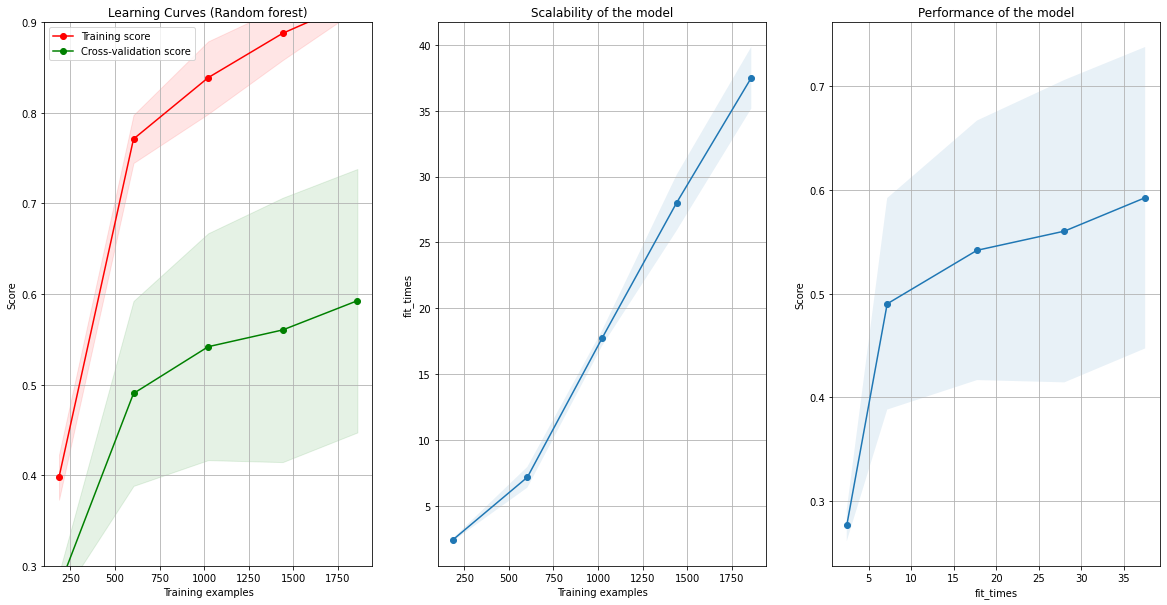

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 10))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


title = "Learning Curves (Random forest)"

plot_learning_curve(
    rfc, title, X_train2, y_train2, ylim=(0.3, 0.9), cv=5, n_jobs=-1
)

plt.show()


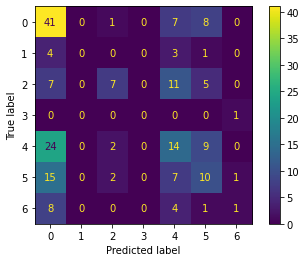

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, predictions, labels=labels)
